### Default Imports

In [381]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup

%matplotlib inline

### Modeling imports

## Doing the modeling!

In [382]:
merged = pd.read_csv('./data/merged_v3.csv')
merged.head()

,year,player,listed_pos,age,tm_name,g,gs,mp,per,ts%,...,blk,tov,pf,pts,year-player,award_tm,award_pos,starter,reserve,all_star
0,1989.0,kareem abdul-jabbar,C,41.0,LAL,74.0,74.0,1695.0,12.9,0.511,...,85.0,95.0,196.0,748.0,1989.0kareem abdul-jabbar,0,C,0.0,1.0,1.0
1,1989.0,mark acres,C,26.0,BOS,62.0,0.0,632.0,8.2,0.507,...,6.0,23.0,94.0,137.0,1989.0mark acres,0,C,0.0,0.0,0.0
2,1989.0,michael adams,PG,26.0,DEN,77.0,77.0,2787.0,17.5,0.567,...,11.0,180.0,149.0,1424.0,1989.0michael adams,0,PG,0.0,0.0,0.0
3,1989.0,mark aguirre,SF,29.0,TOT,80.0,76.0,2597.0,16.4,0.524,...,36.0,208.0,229.0,1511.0,1989.0mark aguirre,0,SF,0.0,0.0,0.0
4,1989.0,danny ainge,PG,29.0,TOT,73.0,54.0,2377.0,18.0,0.554,...,8.0,145.0,186.0,1281.0,1989.0danny ainge,0,PG,0.0,0.0,0.0


In [383]:
merged['target'] = merged['award_tm'].map(lambda x: 1 if x > 0 else 0)

In [384]:
awardpos_dict = {'C':'C',
                 'PG': 'G',
                 'SF':'F',
                 'PF':'F',
                 'SG': 'G',
                 'F':'F',
                 'G':'G'}

In [385]:
merged['award_pos'] = merged['award_pos'].apply(lambda x: awardpos_dict.get(x))

**Notes**
- Need to actually hold out a couple years fully for unseen data. So we'll have:
    - Train data (20)
    - Test data (6)
    - Holdout data (2)
- Look up `Categorical Encoder`

In [386]:
## gonna drop 1999 because of no all star game...
model_df = merged[merged['year'] != 1999]


train_yrs = [1989, 1990, 1991,
             1994, 1995,
             1997, 1998, 2000,
             2002, 2003, 2004,
             2006, 2007, 2008,
             2010, 2011, 2012,
             2014, 2015, 2016]
             
test_yrs = [1992,
            1996,
            2001,
            2005,
            2013,
            2017]

hold_yrs = [1993, 2009]

drop_cols = ['target', 'year-player', 'player', 'award_tm', 'listed_pos']

X_train = model_df.drop(drop_cols, axis=1).loc[model_df['year'].isin(train_yrs)].reset_index(drop=True)
X_test = model_df.drop(drop_cols, axis=1).loc[model_df['year'].isin(test_yrs)].reset_index(drop=True)

y_train = model_df.loc[model_df['year'].isin(train_yrs), 'target']
y_test = model_df.loc[model_df['year'].isin(test_yrs), 'target']

X_hold = model_df.drop(drop_cols, axis=1).loc[model_df['year'].isin(hold_yrs)].reset_index(drop=True)
y_hold = model_df.loc[model_df['year'].isin(hold_yrs), 'target']

print('Train shapes',X_train.shape, y_train.shape)
print('Test shapes',X_test.shape, y_test.shape)
print('Hold shapes', X_hold.shape, y_hold.shape)

Train shapes (8736, 52) (8736,)
Test shapes (2671, 52) (2671,)
Hold shapes (833, 52) (833,)


### Start here!!
- model TTS starting point

In [387]:
## saving progress
# X_train.to_csv('./data/X_train.csv')
# X_test.to_csv('./data/X_test.csv')
# y_train.to_csv('./data/y_train.csv')
# y_test.to_csv('./data/y_test.csv')
# X_hold.to_csv('./data/X_hold.csv')
# y_hold.to_csv('./data/y_hold.csv')

# X_train = pd.read_csv('./data/X_train.csv', index_col=0)
# X_test = pd.read_csv('./data/X_test.csv', index_col=0)
# y_train = pd.read_csv('./data/y_train.csv', index_col=0)
# y_test = pd.read_csv('./data/y_test.csv', index_col=0)
# X_hold = pd.read_csv('./data/X_hold.csv', index_col=0)
# y_hold = pd.read_csv('./data/y_hold.csv', index_col=0)

## Model time!!
1. Set up pipelines!

In [388]:
X_train.dtypes[X_train.dtypes != float]

tm_name      object
award_pos    object
dtype: object

** Need to do either dummies or Categorical Encoding for non-numerical cols**
- `['tm_name', 'award_pos']`
- Let's try both

In [46]:
%run classes.py

In [389]:
X_train.head()

,year,age,tm_name,g,gs,mp,per,ts%,3par,ftr,...,ast,stl,blk,tov,pf,pts,award_pos,starter,reserve,all_star
0,1989.0,41.0,LAL,74.0,74.0,1695.0,12.9,0.511,0.005,0.250,...,74.0,38.0,85.0,95.0,196.0,748.0,C,0.0,1.0,1.0
1,1989.0,26.0,BOS,62.0,0.0,632.0,8.2,0.507,0.009,0.421,...,19.0,19.0,6.0,23.0,94.0,137.0,C,0.0,0.0,0.0
2,1989.0,26.0,DEN,77.0,77.0,2787.0,17.5,0.567,0.431,0.363,...,490.0,166.0,11.0,180.0,149.0,1424.0,G,0.0,0.0,0.0
3,1989.0,29.0,TOT,80.0,76.0,2597.0,16.4,0.524,0.137,0.309,...,278.0,45.0,36.0,208.0,229.0,1511.0,F,0.0,0.0,0.0
4,1989.0,29.0,TOT,73.0,54.0,2377.0,18.0,0.554,0.290,0.228,...,402.0,93.0,8.0,145.0,186.0,1281.0,G,0.0,0.0,0.0


In [390]:
# from classes import CategoricalEncoder
# from sklearn.utils import check_array

# ce = CategoricalEncoder()

# ce.fit(X_train[['tm_name']])

# X_train['tm_name'] = ce.transform(X_train[['tm_name']]).todense()

# X_train['tm_name'].value_counts()

In [391]:
X_train['tm_name'].unique()

array(['LAL', 'BOS', 'DEN', 'TOT', 'WSB', 'SAC', 'SAS', 'POR', 'PHI',
       'NJN', 'UTA', 'SEA', 'LAC', 'ATL', 'DAL', 'CHH', 'GSW', 'MIL',
       'NYK', 'CHI', 'PHO', 'HOU', 'MIA', 'CLE', 'DET', 'IND', 'ORL',
       'MIN', 'VAN', 'TOR', 'WAS', 'MEM', 'NOH', 'NOK', 'CHA', 'OKC',
       'NOP', 'BRK', 'CHO'], dtype=object)

**Some data cleaning still!**
- Need to change some team names from expansion, moving, and other random team seasons to match

In [392]:
team_dict = {'NJN': 'BRK', 'NOH':'NOP', 'WSB':'WAS', 'NOK':'NOP', 'SEA':'OKC', 'CHH':'CHA', 'VAN':'MEM', 'CHO':'CHA'}

In [393]:
X_train['tm_name'] = X_train['tm_name'].map(lambda x: x if team_dict.get(x) == None else team_dict.get(x))
X_test['tm_name'] = X_test['tm_name'].map(lambda x: x if team_dict.get(x) == None else team_dict.get(x))
X_hold['tm_name'] = X_hold['tm_name'].map(lambda x: x if team_dict.get(x) == None else team_dict.get(x))

#### Time to set up a process for label, then one-hot encoding
- For our two categorical columns

In [394]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

le1 = LabelEncoder()
X_train['tm_name_le'] = le1.fit_transform(X_train['tm_name'])
X_test['tm_name_le'] = le1.transform(X_test['tm_name'])
X_hold['tm_name_le'] = le1.transform(X_hold['tm_name'])

In [395]:


onehot = OneHotEncoder(sparse=False)
# X_train['tm_name'] = 
oh_train = onehot.fit_transform(X_train['tm_name_le'].values.reshape(-1,1))
oh_test = onehot.transform(X_test['tm_name_le'].values.reshape(-1, 1))
oh_hold = onehot.transform(X_hold['tm_name_le'].values.reshape(-1, 1))


In [396]:
tm_name_cols = ['tm_encode_' + i for i in np.sort(X_train.tm_name.unique())]
X_train = pd.concat([X_train, pd.DataFrame(oh_train, columns=tm_name_cols)], axis=1)\
                    .drop(['tm_name', 'tm_name_le', 'year'], axis=1)

X_test = pd.concat([X_test, pd.DataFrame(oh_test, columns=tm_name_cols)], axis=1)\
                    .drop(['tm_name', 'tm_name_le', 'year'], axis=1)
    
X_hold = pd.concat([X_hold, pd.DataFrame(oh_hold, columns=tm_name_cols)], axis=1)\
                    .drop(['tm_name', 'tm_name_le', 'year'], axis=1)

In [397]:
X_train.shape

(8736, 81)

In [398]:
X_test.head()

,age,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,...,tm_encode_ORL,tm_encode_PHI,tm_encode_PHO,tm_encode_POR,tm_encode_SAC,tm_encode_SAS,tm_encode_TOR,tm_encode_TOT,tm_encode_UTA,tm_encode_WAS
0,23.0,71.0,1.0,934.0,13.5,0.533,0.000,0.280,9.5,20.9,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22.0,81.0,11.0,1538.0,12.6,0.469,0.111,0.128,1.5,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,29.0,68.0,6.0,926.0,10.1,0.576,0.020,0.444,11.4,19.2,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29.0,78.0,78.0,2795.0,17.1,0.506,0.313,0.292,2.2,10.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,27.0,76.0,8.0,1175.0,10.9,0.477,0.113,0.176,5.7,9.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [399]:
X_hold.head()

,age,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,...,tm_encode_ORL,tm_encode_PHI,tm_encode_PHO,tm_encode_POR,tm_encode_SAC,tm_encode_SAS,tm_encode_TOR,tm_encode_TOT,tm_encode_UTA,tm_encode_WAS
0,24.0,75.0,52.0,1311.0,13.2,0.551,0.002,0.245,11.0,18.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,23.0,81.0,81.0,2710.0,15.6,0.515,0.140,0.165,2.0,6.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,30.0,18.0,7.0,269.0,8.9,0.571,0.041,0.327,10.8,17.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,30.0,70.0,70.0,2499.0,15.6,0.543,0.255,0.333,2.3,8.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,28.0,68.0,15.0,1164.0,8.4,0.484,0.083,0.170,4.2,8.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Now need to repeat for `'award_pos'`

In [400]:
le2 = LabelEncoder()
X_train['award_pos_le'] = le2.fit_transform(X_train['award_pos'])
X_test['award_pos_le'] = le2.transform(X_test['award_pos'])
X_hold['award_pos_le'] = le2.transform(X_hold['award_pos'])

In [401]:
twoh2ot = OneHotEncoder(sparse=False)

oh2_train = twoh2ot.fit_transform(X_train['award_pos_le'].values.reshape(-1,1))
oh2_test = twoh2ot.transform(X_test['award_pos_le'].values.reshape(-1, 1))
oh2_hold = twoh2ot.transform(X_hold['award_pos_le'].values.reshape(-1, 1))


In [402]:
award_pos_cols = ['pos_encode_' + i for i in np.sort(X_train.award_pos.unique())]
X_train = pd.concat([X_train, pd.DataFrame(oh2_train, columns=award_pos_cols)], axis=1)\
                    .drop(['award_pos', 'award_pos_le'], axis=1)

X_test = pd.concat([X_test, pd.DataFrame(oh2_test, columns=award_pos_cols)], axis=1)\
                    .drop(['award_pos', 'award_pos_le'], axis=1)
    
X_hold = pd.concat([X_hold, pd.DataFrame(oh2_hold, columns=award_pos_cols)], axis=1)\
                    .drop(['award_pos', 'award_pos_le'], axis=1)

In [403]:
X_train.shape, X_test.shape, X_hold.shape

((8736, 83), (2671, 83), (833, 83))

## Saving for real:

In [404]:
## saving progress
# X_train.to_csv('./data/X_train.csv')
# X_test.to_csv('./data/X_test.csv')
# y_train.to_csv('./data/y_train.csv')
# y_test.to_csv('./data/y_test.csv')
# X_hold.to_csv('./data/X_hold.csv')
# y_hold.to_csv('./data/y_hold.csv')

# X_train = pd.read_csv('./data/X_train.csv', index_col=0)
# X_test = pd.read_csv('./data/X_test.csv', index_col=0)
# y_train = pd.read_csv('./data/y_train.csv', index_col=0)
# y_test = pd.read_csv('./data/y_test.csv', index_col=0)
# X_hold = pd.read_csv('./data/X_hold.csv', index_col=0)
# y_hold = pd.read_csv('./data/y_hold.csv', index_col=0)

### Let's import what we need for Pipelines

In [405]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion

In [406]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column    
    def fit(self, X, y=None):
        return self 
    def transform(self, X, y=None):
        return X[self.column].values

### Okay, now find which columns for each FE and set them up

In [407]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.model_selection import cross_val_score

In [910]:
num_cols = list(X_train.columns[:46])

cat_cols = list(X_train.columns[46:])

In [839]:
model = LogisticRegressionCV(random_state=64)

In [840]:
num_pipe = Pipeline([
    ('fe', FeatureExtractor(num_cols)),
    ('ss', StandardScaler())
])

In [841]:
cat_pipe = Pipeline([
    ('fe', FeatureExtractor(cat_cols))
])

In [842]:
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            
            ('nums', num_pipe),
            
            ('onehots', cat_pipe)
        ])), 
    ('model', model)
])

In [843]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('nums', Pipeline(memory=None,
     steps=[('fe', FeatureExtractor(column=['age', 'g', 'gs', 'mp', 'per', 'ts%', '3par', 'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%', 'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm'...'l2', random_state=64,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

In [489]:
print(cross_val_score(pipeline, X_test, y_test))
print(cross_val_score(pipeline, X_test, y_test).mean())

[0.98428732 0.98764045 0.98876404]
0.986897270667558


### Well! that's pretty good..

In [415]:
pred_test = pd.concat([model_df.loc[model_df['year'].isin(test_yrs)].reset_index(drop=True), 
           pd.Series(pipeline.predict_proba(X_test)[:,1])],
          axis=1).rename(columns={0:'proba'})

In [416]:
pred_test[(pred_test['year'] == 1992) & (pred_test['award_pos'].str.contains('C'))]\
.sort_values(by='proba', ascending=False)\
.loc[:, ['year', 'player', 'age', 'tm_name', 'g', 'gs', 'per', 'ts%', 'award_tm', 'award_pos', 'proba']][:10]

,year,player,age,tm_name,g,gs,per,ts%,award_tm,award_pos,proba
294,1992.0,david robinson,26.0,SAS,68.0,68.0,27.5,0.597,1,C,0.977669
112,1992.0,patrick ewing,29.0,NYK,82.0,82.0,22.8,0.563,2,C,0.962081
84,1992.0,brad daugherty,26.0,CLE,73.0,73.0,23.0,0.629,3,C,0.645236
251,1992.0,hakeem olajuwon,29.0,HOU,70.0,69.0,23.7,0.553,0,C,0.640779
215,1992.0,moses malone,36.0,MIL,82.0,77.0,19.2,0.556,0,C,0.062527
110,1992.0,pervis ellison,24.0,WSB,66.0,64.0,19.9,0.574,0,C,0.031803
243,1992.0,dikembe mutombo,25.0,DEN,71.0,71.0,16.5,0.540,0,C,0.028349
257,1992.0,robert parish,38.0,BOS,79.0,79.0,18.9,0.571,0,C,0.021781
372,1992.0,hot rod,29.0,CLE,80.0,12.0,18.6,0.569,0,C,0.009303
312,1992.0,rony seikaly,26.0,MIA,79.0,78.0,16.6,0.554,0,C,0.005919


In [490]:
coefdf = pd.DataFrame(pipeline.named_steps['model'].coef_, columns=X_test.columns).T.rename(columns={0: 'coef'})

In [491]:
coefdf['abs_coef'] = coefdf['coef'].apply(lambda x: abs(x))

In [492]:
coefdf.sort_values(by='abs_coef', ascending=False)

,coef,abs_coef
all_star,1.176122,1.176122
g,-1.092843,1.092843
starter,0.928961,0.928961
ws,0.898041,0.898041
vorp,-0.742981,0.742981
usg%,0.742946,0.742946
ows,0.723912,0.723912
dws,0.689437,0.689437
pf,-0.669874,0.669874
tm_encode_ATL,-0.642510,0.642510


## Nice, let's put all the pipeline stuff into one cell with variables
- That way, I can rerun a bunch of times easily :)

In [494]:
# set columns to do FEs on
num_cols = list(X_train.columns[:46])
cat_cols = list(X_train.columns[46:])

# set which model I'm going to use
model = RandomForestClassifier(random_state=64)


## set up the feature pipelines for numerical and categorical columns
num_pipe = Pipeline([
    ('fe', FeatureExtractor(num_cols)),
    ('ss', StandardScaler())
])

cat_pipe = Pipeline([
    ('fe', FeatureExtractor(cat_cols))
])


## set up final pipeline with Feature Union
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            
            ('nums', num_pipe),
            
            ('onehots', cat_pipe)
        ])), 
    ('model', model)
])


## fit the model to the training data
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('nums', Pipeline(memory=None,
     steps=[('fe', FeatureExtractor(column=['age', 'g', 'gs', 'mp', 'per', 'ts%', '3par', 'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%', 'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm'...stimators=10, n_jobs=1,
            oob_score=False, random_state=64, verbose=0, warm_start=False))])

In [495]:
print('Scores on validation data (test)')
print(cross_val_score(pipeline, X_test, y_test))
print(cross_val_score(pipeline, X_test, y_test).mean())
print()
print('Scores on test data (hold)')
print(cross_val_score(pipeline, X_hold, y_hold))
print(cross_val_score(pipeline, X_hold, y_hold).mean())

Scores on validation data (test)
[0.98092031 0.98202247 0.98089888]
0.9812805541894182

Scores on test data (hold)
[0.97482014 0.98201439 0.98916968]
0.9820014024881178


### Examining feature importances
- Gonna add RF feature importances to compare against LogReg

In [496]:
coefdf['rf_coefs'] = pipeline.named_steps['model'].feature_importances_
coefdf.head()

,coef,abs_coef,rf_coefs
age,0.166105,0.166105,0.005781
g,-1.092843,1.092843,0.006122
gs,0.238052,0.238052,0.012171
mp,-0.224338,0.224338,0.009039
per,-0.016126,0.016126,0.075751


In [497]:
# rename columns for clarity
coefdf.rename(columns={'coef': 'logreg_coef', 'abs_coef':'logreg_abs_coef'}, inplace=True)

In [498]:
# create standardized version of DF for comparison, since coefs are on dif scales
norm_coef = (coefdf - coefdf.mean()) / coefdf.std()

In [433]:
score_cols = ['Dataset', 'Cross-Val Mean', 'Cross-Val Scores', 'CV sd.']
valdata = ['Validation', cross_val_score(pipeline, X_test, y_test).mean(), ["{:.3f}".format(i) for i in cross_val_score(pipeline, X_test, y_test)], 
           "{:.4f}".format(cross_val_score(pipeline, X_test, y_test).std())]
testdata = ['Test (hold)', cross_val_score(pipeline, X_hold, y_hold).mean(), ["{:.3f}".format(i) for i in cross_val_score(pipeline, X_hold, y_hold)], 
           "{:.4f}".format(cross_val_score(pipeline, X_hold, y_hold).std())]
baseline = ['Baseline', 0.9669117647058824, '', '']

pd.DataFrame(data=[valdata, testdata, baseline], columns=score_cols)

,Dataset,Cross-Val Mean,Cross-Val Scores,CV sd.
0,Validation,0.981281,"[0.981, 0.982, 0.981]",0.0005
1,Test (hold),0.982001,"[0.975, 0.982, 0.989]",0.0059
2,Baseline,0.966912,,


In [422]:
1 - model_df.target.mean()

0.9669117647058824

In [438]:
def piperoni(modelname):
    """Takes in instantiation of Classifier Model, returns cross-validated evaluation.
    Please close parens! -- e.g. LogisticRegression()"""
    
    # set columns to do FEs on
    num_cols = list(X_train.columns[:46])
    cat_cols = list(X_train.columns[46:])

    # set which model I'm going to use
    model = modelname


    ## set up the feature pipelines for numerical and categorical columns
    num_pipe = Pipeline([
        ('fe', FeatureExtractor(num_cols)),
        ('ss', StandardScaler())
    ])

    cat_pipe = Pipeline([
        ('fe', FeatureExtractor(cat_cols))
    ])


    ## set up final pipeline with Feature Union
    pipeline = Pipeline([
        ('union', FeatureUnion(
            transformer_list=[

                ('nums', num_pipe),

                ('onehots', cat_pipe)
            ])), 
        ('model', model)
    ])


    ## fit the model to the training data
    pipeline.fit(X_train, y_train)
    

    score_cols = ['Dataset', 'Cross-Val Mean', 'Cross-Val Scores', 'CV sd.']
    valdata = ['Validation', cross_val_score(pipeline, X_test, y_test).mean(), ["{:.3f}".format(i) for i in cross_val_score(pipeline, X_test, y_test)], 
               "{:.4f}".format(cross_val_score(pipeline, X_test, y_test).std())]
    testdata = ['Test (hold)', cross_val_score(pipeline, X_hold, y_hold).mean(), ["{:.3f}".format(i) for i in cross_val_score(pipeline, X_hold, y_hold)], 
               "{:.4f}".format(cross_val_score(pipeline, X_hold, y_hold).std())]
    baseline = ['Baseline', 0.9669117647058824, '', '']

    return pd.DataFrame(data=[valdata, testdata, baseline], columns=score_cols)

In [435]:
piperoni(LogisticRegression(random_state=64))

,Dataset,Cross-Val Mean,Cross-Val Scores,CV sd.
0,Validation,0.988020,"[0.985, 0.989, 0.990]",0.0019
1,Test (hold),0.980802,"[0.975, 0.978, 0.989]",0.0061
2,Baseline,0.966912,,


In [436]:
piperoni(RandomForestClassifier(random_state=64))

,Dataset,Cross-Val Mean,Cross-Val Scores,CV sd.
0,Validation,0.981281,"[0.981, 0.982, 0.981]",0.0005
1,Test (hold),0.982001,"[0.975, 0.982, 0.989]",0.0059
2,Baseline,0.966912,,


In [439]:
from imblearn.ensemble import BalancedBaggingClassifier

In [443]:
piperoni(BalancedBaggingClassifier())

,Dataset,Cross-Val Mean,Cross-Val Scores,CV sd.
0,Validation,0.964065,"[0.951, 0.969, 0.975]",0.0207
1,Test (hold),0.956778,"[0.924, 0.968, 0.928]",0.0034
2,Baseline,0.966912,,


In [805]:
model_list = [LogisticRegression(), RandomForestClassifier(), BalancedBaggingClassifier(), 
              ExtraTreeClassifier(), DecisionTreeClassifier()]

[(str(m)[0:str(m).find('(')], "{:.3f}".format(piperoni(m).loc[1, 'Cross-Val Mean'])) for m in model_list]
    

[('LogisticRegression', '0.981'),
 ('RandomForestClassifier', '0.976'),
 ('BalancedBaggingClassifier', '0.956'),
 ('ExtraTreeClassifier', '0.971'),
 ('DecisionTreeClassifier', '0.968')]

## Visualizing
- Let's plot out a comparison to see how each classifier weights each feature
- Dendrogram
...etc

In [534]:
coefdf.head()

,logreg_coef,logreg_abs_coef,rf_coefs
age,0.166105,0.166105,0.005781
g,-1.092843,1.092843,0.006122
gs,0.238052,0.238052,0.012171
mp,-0.224338,0.224338,0.009039
per,-0.016126,0.016126,0.075751


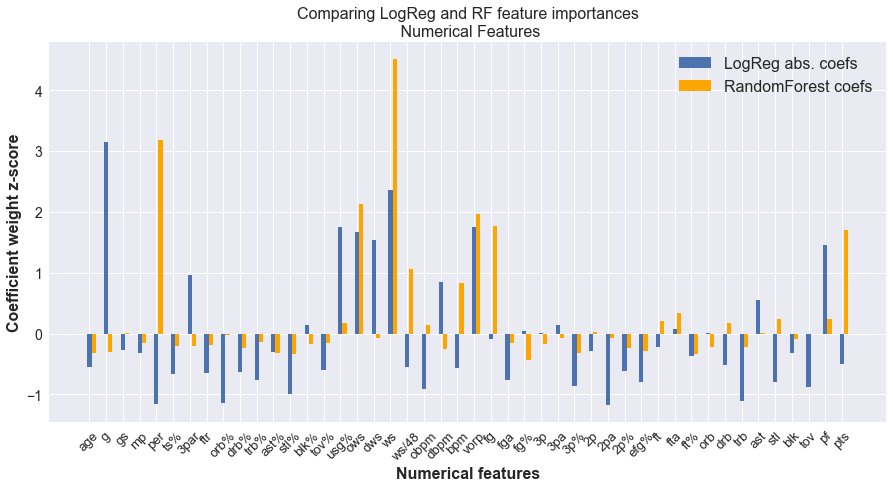

In [538]:
# can only compare LR_abs to RF b/c RF only has weight, not direction

ticklocs = np.arange(0, norm_coef.loc[num_cols].shape[0])
ticklabels = norm_coef.loc[num_cols].index

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7));

plt.bar(x = ticklocs, height=norm_coef.loc[num_cols, 'logreg_abs_coef'], label='LogReg abs. coefs', 
        width=0.25);

plt.bar(x = ticklocs+0.25, height=norm_coef.loc[num_cols, 'rf_coefs'], label='RandomForest coefs', 
        width=0.25, color='orange');


plt.xticks(ticklocs, ticklabels, rotation=45, fontsize=13);
plt.tick_params('y', labelsize=14);

plt.xlabel('Numerical features', fontsize=16, weight='bold')
plt.ylabel('Coefficient weight z-score', fontsize=16, weight='bold')

plt.legend(fontsize=16);
plt.title('Comparing LogReg and RF feature importances\n Numerical Features', fontsize=16);

**Dendrogram**

In [553]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [551]:
dt = DecisionTreeClassifier(random_state=64)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=64,
            splitter='best')

Decision Tree


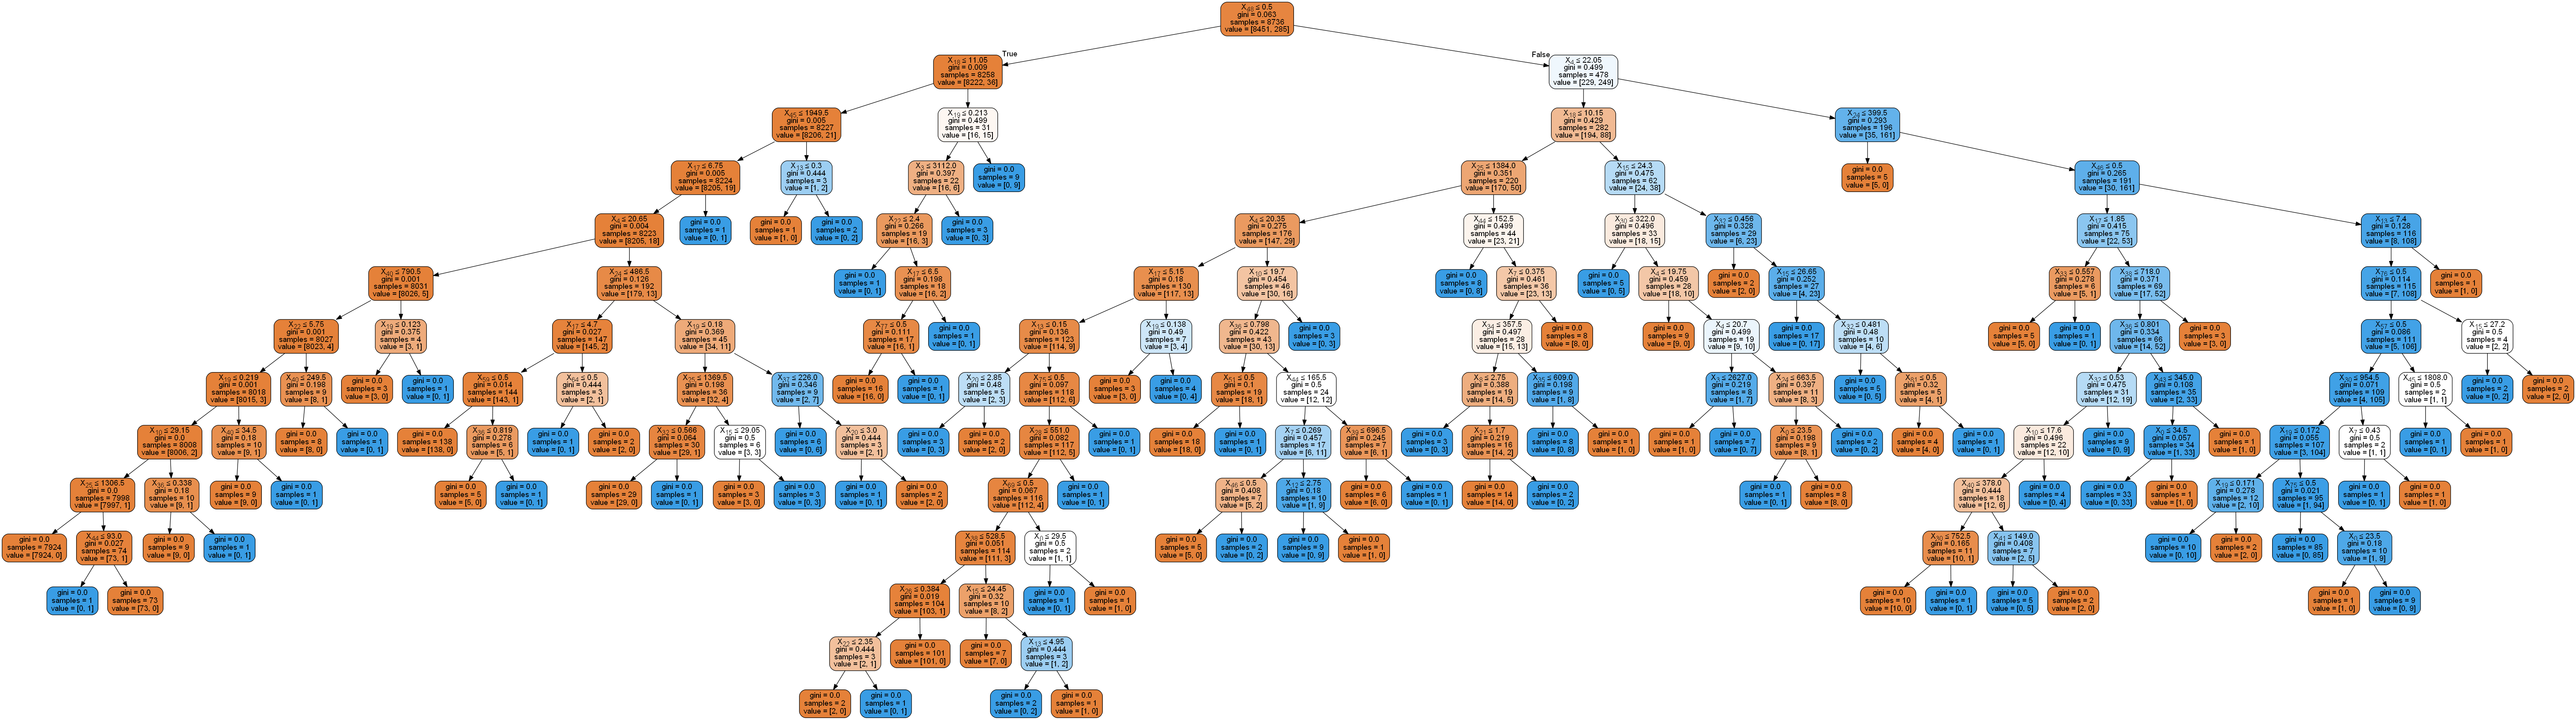

In [554]:
dot_data = StringIO()  

export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
print('Decision Tree')
Image(graph.create_png())  

**Confusion Matrix**

In [578]:
from sklearn.metrics import confusion_matrix

In [602]:
pipeline.named_steps['model']

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=64,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

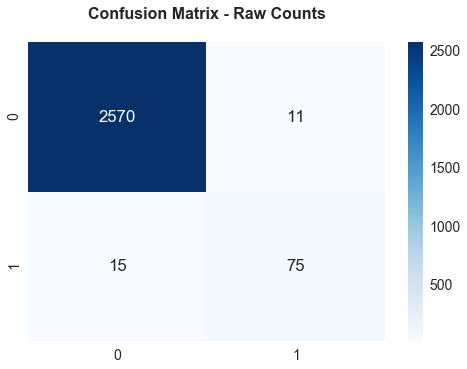

In [637]:
# raw num
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix(y_test, pipeline.predict(X_test)), cmap='Blues', annot=True, fmt='d');
plt.title('Confusion Matrix - Raw Counts\n', fontsize=16, weight='bold');

Total Accuracy: 98.69%


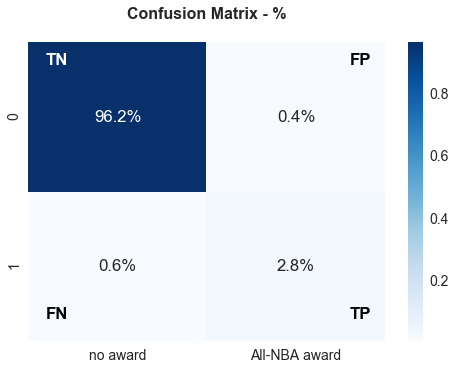

In [716]:
# raw num
sns.set(font_scale=1.4)

conf = confusion_matrix(y_test, pipeline.predict(X_test))/X_test.shape[0]

sns.heatmap(conf, cmap='Blues', annot=True, 
           xticklabels=['no award', 'All-NBA award'], fmt='.1%');

#label conf. matrix
plt.text(x = .1, y = 1.85, s='TN', color='white', weight='bold')
plt.text(x = 1.8, y = 1.85, s='FP', color='black', weight='bold')
plt.text(x = .1, y = .15, s='FN', color='black', weight='bold')
plt.text(x = 1.8, y = .15, s='TP', color='black', weight='bold')

# label things
plt.tick_params(labelsize=14);
plt.title('Confusion Matrix - %\n', fontsize=16, weight='bold');

print('Total Accuracy: ' + "{:.2%}".format(cross_val_score(pipeline, X_test, y_test).mean()))

0.986897270667558

Total Accuracy: 98.69%


In [697]:
import plotter

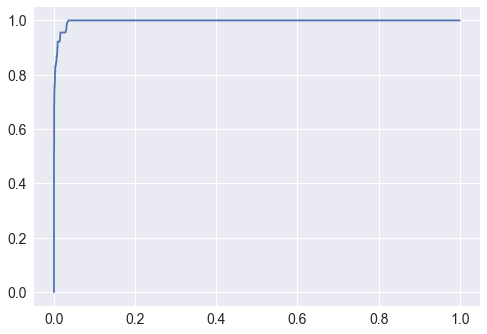

In [698]:
plotter.plot_auc(pipeline, X_test, y_test)

In [604]:
tn, fp, fn, tp = confusion_matrix(y_test, pipeline.predict(X_test)).ravel()

In [605]:
confusion_matrix(y_test, pipeline.predict(X_test)).ravel()

array([2570,   11,   15,   75], dtype=int64)

#### let's make a function

In [717]:
def plot_confusion(estimator, X, y_true):
    """Plots a labeled confusion matrix for binary classification estimators.
    Annotates with %s for TN, FP, FN, TP."""
    
    # set font to be bigger
    sns.set(font_scale=1.4)

    # set your confusion matrix
    conf = confusion_matrix(y_true, estimator.predict(X))/X.shape[0]

    sns.heatmap(conf, cmap='Blues', annot=True, fmt='.1%');

    #label conf. matrix
    plt.text(x = .1, y = 1.85, s='TN', color='gray', weight='bold')
    plt.text(x = 1.8, y = 1.85, s='FP', color='gray', weight='bold')
    plt.text(x = .1, y = .15, s='FN', color='gray', weight='bold')
    plt.text(x = 1.8, y = .15, s='TP', color='gray', weight='bold')

    # label other things
    plt.tick_params(labelsize=14);
    plt.title('Confusion Matrix - %\n', fontsize=16, weight='bold');
    
    print('Total Accuracy: ' + "{:.2%}".format(cross_val_score(estimator, X, y_true).mean()))

Total Accuracy: 98.69%


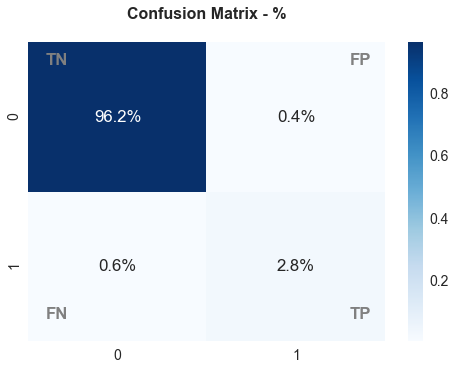

In [718]:
plot_confusion(pipeline, X_test, y_test)

### Moving on...
- Gotta pull out the actual teams

In [753]:
pd.Series(pipeline.predict_proba(X_test)[:,1])[:10]

0    0.000159
1    0.000054
2    0.000041
3    0.032825
4    0.000019
5    0.000744
6    0.000541
7    0.000194
8    0.000571
9    0.000097
dtype: float64

In [735]:
X_test.shape, y_test.shape

((2671, 83), (2671,))

In [791]:
## make a DF
pred_test_lr1 = pd.concat([model_df.loc[model_df['year'].isin(test_yrs), ['year','player', 'award_tm', 'listed_pos', 'tm_name']].reset_index(drop=True),
                           X_test, y_test.reset_index(drop=True).reset_index(drop=True), 
                           pd.Series(pipeline.predict_proba(X_test)[:,1])],
                          axis=1).rename(columns={0:'proba'})

In [792]:
pred_test_lr1.head()

,year,player,award_tm,listed_pos,tm_name,age,g,gs,mp,per,...,tm_encode_SAS,tm_encode_TOR,tm_encode_TOT,tm_encode_UTA,tm_encode_WAS,pos_encode_C,pos_encode_F,pos_encode_G,target,proba
0,1992.0,alaa abdelnaby,0,PF,POR,23.0,71.0,1.0,934.0,13.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.000159
1,1992.0,mahmoud abdul-rauf,0,PG,DEN,22.0,81.0,11.0,1538.0,12.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.000054
2,1992.0,mark acres,0,C,ORL,29.0,68.0,6.0,926.0,10.1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.000041
3,1992.0,michael adams,0,PG,WSB,29.0,78.0,78.0,2795.0,17.1,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0.032825
4,1992.0,rafael addison,0,SF,NJN,27.0,76.0,8.0,1175.0,10.9,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.000019


In [793]:
pred_test_lr1.year.unique()

array([1992., 1996., 2001., 2005., 2013., 2017.])

In [797]:
mask = (pred_test_lr1['pos_encode_C'] == 1) & (pred_test_lr1['year'] == 1992)
interestcols = ['year','g', 'player', 'tm_name','award_tm', 'listed_pos', 'target', 'proba']

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(5)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
294,1992.0,68.0,david robinson,SAS,1,C,1,0.977669
112,1992.0,82.0,patrick ewing,NYK,2,C,1,0.962081
84,1992.0,73.0,brad daugherty,CLE,3,C,1,0.645236
251,1992.0,70.0,hakeem olajuwon,HOU,0,C,0,0.640779
215,1992.0,82.0,moses malone,MIL,0,C,0,0.062527


In [798]:
mask = (pred_test_lr1['pos_encode_G'] == 1) & (pred_test_lr1['year'] == 1996)

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(10)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
575,1996.0,82.0,michael jordan,CHI,1,SG,1,0.999743
539,1996.0,82.0,anfernee hardaway,ORL,1,PG,1,0.972628
669,1996.0,81.0,gary payton,SEA,2,PG,1,0.740522
753,1996.0,82.0,john stockton,UTA,2,PG,1,0.710960
426,1996.0,75.0,terrell brandon,CLE,0,PG,0,0.676045
634,1996.0,76.0,reggie miller,IND,3,SG,1,0.322068
700,1996.0,81.0,mitch richmond,SAC,3,SG,1,0.273898
485,1996.0,52.0,clyde drexler,HOU,0,SG,0,0.175874
583,1996.0,81.0,jason kidd,DAL,0,PG,0,0.175399
755,1996.0,67.0,rod strickland,POR,0,PG,0,0.164824


In [803]:
mask = (pred_test_lr1['pos_encode_F'] == 1) & (pred_test_lr1['year'] == 1996)

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(15)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
610,1996.0,82.0,karl malone,UTA,1,PF,1,0.956986
682,1996.0,77.0,scottie pippen,CHI,1,SF,1,0.899076
578,1996.0,79.0,shawn kemp,SEA,2,PF,1,0.876460
407,1996.0,71.0,charles barkley,PHO,3,PF,1,0.850056
550,1996.0,80.0,grant hill,DET,2,SF,1,0.847609
449,1996.0,78.0,cedric ceballos,LAL,0,SF,0,0.182329
570,1996.0,81.0,larry johnson,CHH,0,PF,0,0.106352
501,1996.0,77.0,sean elliott,SAS,0,SF,0,0.103489
405,1996.0,82.0,vin baker,MIL,0,PF,0,0.091030
698,1996.0,79.0,glen rice,CHH,0,SF,0,0.070362


### 2017

In [811]:
## Guards
mask = (pred_test_lr1['pos_encode_G'] == 1) & (pred_test_lr1['year'] == 2017)

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(10)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
2356,2017.0,81.0,james harden,HOU,1,PG,1,0.998919
2642,2017.0,81.0,russell westbrook,OKC,1,PG,1,0.997480
2282,2017.0,79.0,stephen curry,GSW,2,PG,1,0.988191
2608,2017.0,76.0,isaiah thomas,BOS,2,PG,1,0.937593
2636,2017.0,78.0,john wall,WAS,3,PG,1,0.787689
2292,2017.0,74.0,demar derozan,TOR,3,SG,1,0.780063
2399,2017.0,72.0,kyrie irving,CLE,0,PG,0,0.693083
2635,2017.0,79.0,kemba walker,CHO,0,PG,0,0.563189
2450,2017.0,75.0,damian lillard,POR,0,PG,0,0.493494
2611,2017.0,78.0,klay thompson,GSW,0,SG,0,0.376578


In [809]:
## Forwards
mask = (pred_test_lr1['pos_encode_F'] == 1) & (pred_test_lr1['year'] == 2017)

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(10)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
2404,2017.0,74.0,lebron james,CLE,1,SF,1,0.992107
2303,2017.0,62.0,kevin durant,GSW,2,SF,1,0.978391
2445,2017.0,74.0,kawhi leonard,SAS,1,SF,1,0.976372
2250,2017.0,76.0,jimmy butler,CHI,3,SF,1,0.937496
2200,2017.0,80.0,giannis antetokounmpo,MIL,2,SF,1,0.927063
2369,2017.0,73.0,gordon hayward,UTA,0,SF,0,0.554985
2334,2017.0,75.0,paul george,IND,0,SF,0,0.201421
2352,2017.0,61.0,blake griffin,LAC,0,PF,0,0.138897
2348,2017.0,76.0,draymond green,GSW,3,PF,1,0.067673
2490,2017.0,69.0,paul millsap,ATL,0,PF,0,0.048189


In [813]:
## Centers
maskyear = 2017
maskpos = 'C'

mask = (pred_test_lr1['pos_encode_'+maskpos] == 1) & (pred_test_lr1['year'] == maskyear)

pred_test_lr1.loc[mask, interestcols].sort_values(by='proba', ascending=False).head(6)

,year,g,player,tm_name,award_tm,listed_pos,target,proba
2284,2017.0,75.0,anthony davis,NOP,1,C,1,0.969974
2424,2017.0,81.0,deandre jordan,LAC,3,C,1,0.787221
2339,2017.0,81.0,rudy gobert,UTA,2,C,1,0.579996
2274,2017.0,72.0,demarcus cousins,TOT,0,C,0,0.535992
2617,2017.0,82.0,karl-anthony towns,MIN,0,C,0,0.466657
2645,2017.0,77.0,hassan whiteside,MIA,0,C,0,0.262229


### Model Tune up  
**Adding some features**
- Per game features:
    - `'mp', 'fg', 'fga', '2p', '2pa', 'ft', 'fta', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts'`
- `'listed_pos'` label encoded and in model?
- Team stuff...

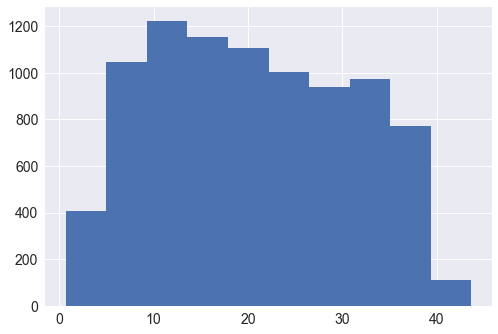

In [819]:
plt.hist(X_train['mp'] / X_train['g']);

In [826]:
## Set columns needed for per game
pergame_cols = ['mp', 'fg', 'fga', '2p', '2pa', 'ft', 'fta', 'orb', 'drb', 
                'trb','ast', 'stl', 'blk', 'tov', 'pf', 'pts']

In [832]:
for i in pergame_cols:
    colname = i + '_per_game'
    X_train[colname] = X_train[i] / X_train['g']
    X_test[colname] = X_test[i] / X_test['g']
    X_hold[colname] = X_hold[i] / X_hold['g']
    
X_train.head()

,age,g,gs,mp,per,ts%,3par,ftr,orb%,drb%,...,fta_per_game,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game
0,41.0,74.0,74.0,1695.0,12.9,0.511,0.005,0.250,7.3,14.2,...,2.229730,1.391892,3.121622,4.513514,1.000000,0.513514,1.148649,1.283784,2.648649,10.108108
1,26.0,62.0,0.0,632.0,8.2,0.507,0.009,0.421,10.9,15.6,...,0.774194,0.951613,1.403226,2.354839,0.306452,0.306452,0.096774,0.370968,1.516129,2.209677
2,26.0,77.0,77.0,2787.0,17.5,0.567,0.431,0.363,2.5,8.3,...,5.103896,0.922078,2.753247,3.675325,6.363636,2.155844,0.142857,2.337662,1.935065,18.493506
3,29.0,80.0,76.0,2597.0,16.4,0.524,0.137,0.309,6.4,10.0,...,4.912500,1.825000,3.000000,4.825000,3.475000,0.562500,0.450000,2.600000,2.862500,18.887500
4,29.0,73.0,54.0,2377.0,18.0,0.554,0.290,0.228,3.3,8.7,...,3.287671,0.972603,2.520548,3.493151,5.506849,1.273973,0.109589,1.986301,2.547945,17.547945


In [833]:
model_list = [LogisticRegression(), RandomForestClassifier(), BalancedBaggingClassifier(), 
              ExtraTreeClassifier(), DecisionTreeClassifier()]

[(str(m)[0:str(m).find('(')], "{:.3f}".format(piperoni(m).loc[1, 'Cross-Val Mean'])) for m in model_list]

[('LogisticRegression', '0.980'),
 ('RandomForestClassifier', '0.976'),
 ('BalancedBaggingClassifier', '0.956'),
 ('ExtraTreeClassifier', '0.953'),
 ('DecisionTreeClassifier', '0.964')]

In [844]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('nums', Pipeline(memory=None,
     steps=[('fe', FeatureExtractor(column=['age', 'g', 'gs', 'mp', 'per', 'ts%', '3par', 'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%', 'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm'...'l2', random_state=64,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0))])

In [847]:
# set columns to do FEs on
num_cols = list(X_train.columns[:46])
cat_cols = list(X_train.columns[46:])

# set which model I'm going to use
model = LogisticRegression(random_state=64)


## set up the feature pipelines for numerical and categorical columns
num_pipe = Pipeline([
    ('fe', FeatureExtractor(num_cols)),
    ('ss', StandardScaler())
])

cat_pipe = Pipeline([
    ('fe', FeatureExtractor(cat_cols))
])


## set up final pipeline with Feature Union
pipeline = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            
            ('nums', num_pipe),
            
            ('onehots', cat_pipe)
        ])), 
    ('model', model)
])


## fit the model to the training data
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('nums', Pipeline(memory=None,
     steps=[('fe', FeatureExtractor(column=['age', 'g', 'gs', 'mp', 'per', 'ts%', '3par', 'ftr', 'orb%', 'drb%', 'trb%', 'ast%', 'stl%', 'blk%', 'tov%', 'usg%', 'ows', 'dws', 'ws', 'ws/48', 'obpm', 'dbpm'...alty='l2', random_state=64, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [864]:
print('Validation')
print(cross_val_score(pipeline, X_test, y_test))
print(cross_val_score(pipeline, X_test, y_test).mean())
print()
print('Test')
print(cross_val_score(pipeline, X_hold, y_hold))
print(cross_val_score(pipeline, X_hold, y_hold).mean())

Validation
[0.98653199 0.98651685 0.98202247]
0.9850237707915611

Test
[0.97122302 0.98201439 0.98555957]
0.9795989922863152


In [857]:
coefdf_pergame = pd.DataFrame(data=pipeline.named_steps['model'].coef_, index=['coef'], columns=X_train.columns).T

In [861]:
coefdf_pergame['abs_coef'] = coefdf_pergame['coef'].apply(lambda x: abs(x))

In [863]:
coefdf_pergame.sort_values(by='coef', ascending=False)

,coef,abs_coef
mp,1.304598,1.304598
all_star,1.280768,1.280768
ws,1.161161,1.161161
starter,1.043193,1.043193
tm_encode_MIL,0.908948,0.908948
ows,0.805334,0.805334
tm_encode_SAC,0.784415,0.784415
3pa,0.756121,0.756121
dws,0.738020,0.738020
dbpm,0.627587,0.627587


In [915]:
new_num_cols = [i for i in list(coefdf_pergame.index) if i not in cat_cols]

In [916]:
new_num_cols.extend([i + '_per_game' for i in pergame_cols])

In [922]:
coef_compare = pd.concat([coefdf_pergame.loc[new_num_cols, 'coef'], coefdf.loc[new_num_cols, 'logreg_coef'].fillna(0)], axis=1)

C:\Users\james\Anaconda3\envs\dsi\lib\site-packages\pandas\core\indexing.py:1020: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


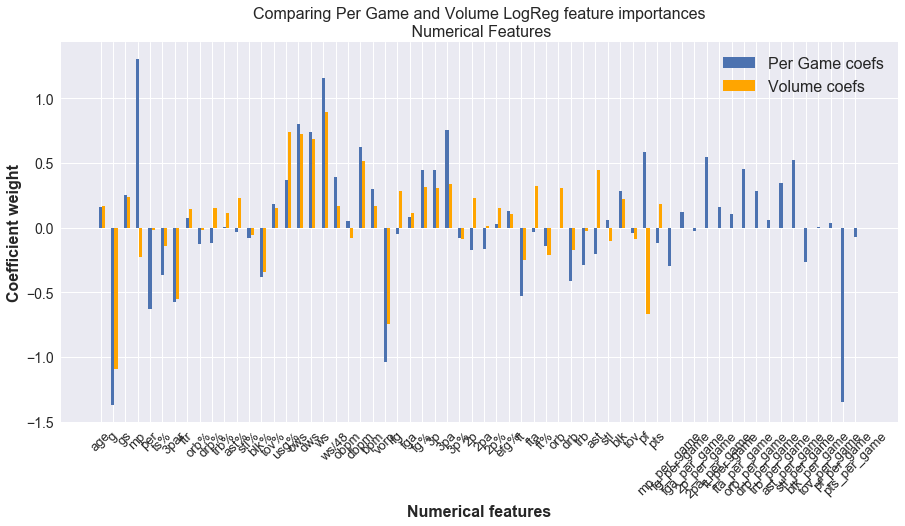

In [930]:
# can only compare LR_abs to RF b/c RF only has weight, not direction

ticklocs = np.arange(0, coef_compare.shape[0])
ticklabels = coef_compare.index

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7));

plt.bar(x = ticklocs, height=coef_compare['coef'], label='Per Game coefs', 
        width=0.25);

plt.bar(x = ticklocs+0.25, height=coef_compare['logreg_coef'], label='Volume coefs', 
        width=0.25, color='orange');


plt.xticks(ticklocs, ticklabels, rotation=45, fontsize=13);
plt.tick_params('y', labelsize=14);

plt.xlabel('Numerical features', fontsize=16, weight='bold')
plt.ylabel('Coefficient weight', fontsize=16, weight='bold')

plt.legend(fontsize=16);
plt.title('Comparing Per Game and Volume LogReg feature importances\n Numerical Features', fontsize=16);

In [924]:
def sign_function(number):
    if number < 0:
        return 1
    else:
        return 0

In [928]:
coef_compare['sign_dif'] = [sign_function(i) for i in coef_compare['coef'] * coef_compare['logreg_coef']]

In [931]:
coef_compare[(coef_compare['sign_dif'] == 1)]

,coef,logreg_coef,sign_dif
mp,1.304598,-0.224338,1
drb%,-0.121489,0.148551,1
ast%,-0.030914,0.230465,1
obpm,0.052021,-0.078533,1
fg,-0.047262,0.283539,1
2p,-0.172785,0.231843,1
2pa,-0.168789,0.010692,1
fta,-0.029871,0.323047,1
orb,-0.004752,0.305408,1
ast,-0.205565,0.442476,1


In [949]:
for year in pred_test_lr1['year'].unique():
    for pos in model_df.award_pos.unique():
#         print(year, 'pos_encode_'+pos)
        
        maskyear = year
        maskpos = pos

        mask = (pred_test_lr1['pos_encode_'+maskpos] == 1) & (pred_test_lr1['year'] == maskyear)

        print(pred_test_lr1.loc[mask, ['year', 'player', 'proba']].sort_values(by='proba', ascending=False).head(6))
        print()
        
#         print(pred_test_lr1.loc[year, ['pos_encode_' + pos]].values)
        
    ## control flow on how many to pull out per position

       year           player     proba
294  1992.0   david robinson  0.977669
112  1992.0    patrick ewing  0.962081
84   1992.0   brad daugherty  0.645236
251  1992.0  hakeem olajuwon  0.640779
215  1992.0     moses malone  0.062527
110  1992.0   pervis ellison  0.031803

       year          player     proba
179  1992.0  michael jordan  0.997455
95   1992.0   clyde drexler  0.959158
332  1992.0   john stockton  0.800642
147  1992.0    tim hardaway  0.630637
175  1992.0   kevin johnson  0.359745
162  1992.0   jeff hornacek  0.356028

       year           player     proba
214  1992.0      karl malone  0.986147
271  1992.0   scottie pippen  0.856573
24   1992.0  charles barkley  0.846692
239  1992.0     chris mullin  0.690472
297  1992.0    dennis rodman  0.403007
138  1992.0     horace grant  0.232570

       year            player     proba
708  1996.0    david robinson  0.997352
661  1996.0   hakeem olajuwon  0.939883
658  1996.0  shaquille o'neal  0.878888
645  1996.0   alonzo mour